# Overlapping analysis with constant attribution score cutoff (top 100) for AMR genes

In [1]:
import pandas as pd


pd.set_option("display.max_columns", None) # show all cols
pd.set_option('display.max_colwidth', None) # show full width of showing cols
pd.set_option("display.expand_frame_repr", False) # print cols side by side as it's supposed to be

In [2]:
import os
import pandas as pd
from pathlib import Path


bedDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'bed_files', 'SAUR')

bedDfList = []
for bedFile in os.listdir(bedDir):
    tubeid = bedFile.split('.')[0].split('_')[0]
    tokensDf = pd.read_csv(Path(bedDir, bedFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score'])
    tokensDf['tube_id'] = tubeid
    bedDfList.append(tokensDf)

bedDf = pd.concat(bedDfList, ignore_index=True)
bedDf


,contig_id,start_position,end_position,tokens,score,tube_id
0,1,0,6,TTTTCTT,0.000064,ALF22G140
1,1,7,9,ACC,-0.000395,ALF22G140
2,1,10,13,GACA,0.001573,ALF22G140
3,1,14,18,AGAAT,-0.000986,ALF22G140
4,1,19,25,TAATTAT,0.000795,ALF22G140
...,...,...,...,...,...,...
176721937,5,181665,181667,CGG,-0.002273,AH21C044
176721938,5,181668,181673,CTCATC,-0.001735,AH21C044
176721939,5,181674,181676,GCA,-0.003468,AH21C044
176721940,5,181677,181680,TCCA,-0.000228,AH21C044


In [3]:
bedDf['token_length'] = bedDf.tokens.apply(lambda x: len(x))
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
0,1,0,6,TTTTCTT,0.000064,ALF22G140,7
1,1,7,9,ACC,-0.000395,ALF22G140,3
2,1,10,13,GACA,0.001573,ALF22G140,4
3,1,14,18,AGAAT,-0.000986,ALF22G140,5
4,1,19,25,TAATTAT,0.000795,ALF22G140,7
...,...,...,...,...,...,...,...
176721937,5,181665,181667,CGG,-0.002273,AH21C044,3
176721938,5,181668,181673,CTCATC,-0.001735,AH21C044,6
176721939,5,181674,181676,GCA,-0.003468,AH21C044,3
176721940,5,181677,181680,TCCA,-0.000228,AH21C044,4


In [4]:
highscoreDf = bedDf.sort_values(by=['score'], ascending=False)[:1000]
highscoreDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
12546445,3,300016,300022,TTATATA,0.401408,AH19K071,7
30627859,4,292501,292505,TCACA,0.392442,AH20J041,5
8636242,4,175077,175082,GAACAT,0.331686,ALF22E035,6
8636234,4,175031,175036,TAAACT,0.329530,ALF22E035,6
20052075,3,307641,307648,TGATTTTT,0.268324,ALF22F089,8
...,...,...,...,...,...,...,...
151041184,4,16239,16242,GTGA,0.038041,ALF22D159,4
32553855,1,706455,706458,TTGA,0.038029,AH21A007,4
134913943,2,359211,359214,ACTG,0.038020,ALF23C140,4
25323140,3,270116,270120,GCTTT,0.038013,AH20I021,5


In [5]:
highscoreDf.shape

(1000, 7)

In [6]:
highscoreDf.token_length.value_counts()

token_length
4     298
6     243
5     229
7     140
8      71
3       8
9       6
2       3
10      2
Name: count, dtype: int64

<Axes: xlabel='token_length', ylabel='Count'>

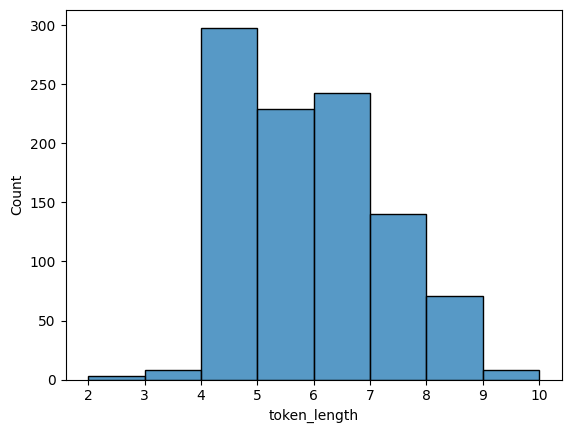

In [7]:
import seaborn as sns

sns.histplot(highscoreDf.token_length, binwidth=1)

## Read amrfinder annotations

In [8]:
import os

import pandas as pd

from pathlib import Path


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

overlappingGenesDict = {}
overlappingAnnotationsDict = {}

for tokenLengthCutoff in range(5, 11):
    print('tokenLengthCutoff: ', str(tokenLengthCutoff))
    tokensDf = highscoreDf[highscoreDf.token_length == tokenLengthCutoff]
    overlappingDfList = []
    for tubeId in tokensDf.tube_id.unique():
        tubeidHighscoreDf = highscoreDf[highscoreDf.tube_id == tubeId]
        amrfinderFile = Path(amrfinderDir, tubeId + '_amr_results.txt')
        if(amrfinderFile.exists()):
            amrfinderDf = pd.read_csv(amrfinderFile, sep='\t')
            mergedDf = tubeidHighscoreDf.merge(
                amrfinderDf,
                how='inner',
                left_on = ['contig_id'],
                right_on = ['Contig id'],
            )
            mergedDf['tube_code'] = tubeId
            tubeidOverlappingDf = mergedDf[(mergedDf.start_position >= mergedDf.Start) & (mergedDf.end_position <= mergedDf.Stop)]
            overlappingDfList.append(mergedDf)

    overlappingDf = pd.concat(overlappingDfList, ignore_index=True)

    overlappingGenesDict['Token Length > ' + str(tokenLengthCutoff)] = overlappingDf['Gene symbol'].unique()
    overlappingAnnotationsDict['Token Length > ' + str(tokenLengthCutoff)] = overlappingDf

tokenLengthCutoff:  5
tokenLengthCutoff:  6
tokenLengthCutoff:  7
tokenLengthCutoff:  8
tokenLengthCutoff:  9
tokenLengthCutoff:  10


## Generate upset plot

/home/vmadmin/workspace/alfred-data-analysis/.venv/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/vmadmin/workspace/alfred-data-analysis/.venv/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the 

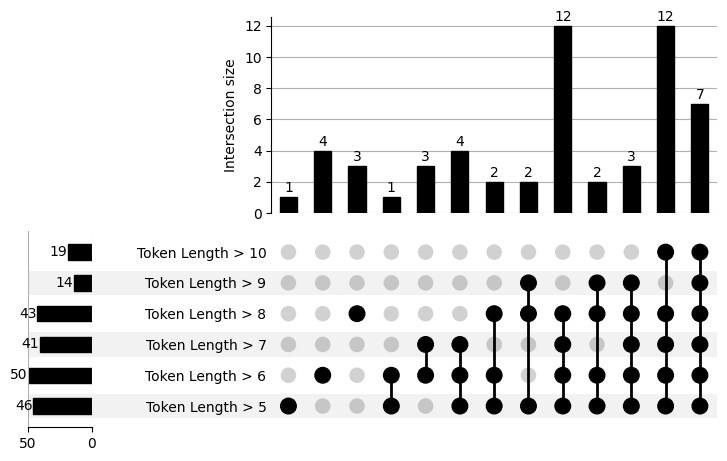

In [9]:
from upsetplot import UpSet

from upsetplot import from_contents


ax_dict = UpSet(from_contents(overlappingGenesDict), show_counts=True, sort_categories_by='input').plot()

## Obtain singature genes

In [10]:
singatureGenes = set()
singatureGenes.update(set.intersection(*[set([v for v in value if str(v) != 'nan']) for key, value in overlappingGenesDict.items()]))
singatureGenes

{'aur', 'fosB', 'hlgA', 'hlgB', 'hlgC', 'icaC', 'lmrS'}

In [11]:
allAnnotationsDf = pd.concat([value for key, value in overlappingAnnotationsDict.items()], ignore_index=True)
allAnnotationsDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description,tube_code
0,4,292501,292505,TCACA,0.392442,AH20J041,5,NaN,4,68552,70078,-,aur,zinc metalloproteinase aureolysin,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,509,509,100.00,99.41,509,EHO93748.1,zinc metalloproteinase aureolysin,NaN,NaN,AH20J041
1,4,292501,292505,TCACA,0.392442,AH20J041,5,NaN,4,113612,114661,+,icaC,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,350,350,100.00,99.43,350,AUU58561.1,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,NaN,NaN,AH20J041
2,4,292501,292505,TCACA,0.392442,AH20J041,5,NaN,4,194491,196494,-,mecA,PBP2a family beta-lactam-resistant peptidoglycan transpeptidase MecA,core,AMR,AMR,BETA-LACTAM,METHICILLIN,EXACTX,668,668,100.00,100.00,668,WP_000721310.1,PBP2a family beta-lactam-resistant peptidoglycan transpeptidase MecA,NaN,NaN,AH20J041
3,4,292501,292505,TCACA,0.392442,AH20J041,5,NaN,4,196594,197568,+,mecR1,beta-lactam sensor/signal transducer MecR1,core,AMR,AMR,BETA-LACTAM,METHICILLIN,PARTIALX,325,585,55.56,100.00,325,WP_000952923.1,beta-lactam sensor/signal transducer MecR1,NaN,NaN,AH20J041
4,4,292501,292505,TCACA,0.392442,AH20J041,5,NaN,4,232115,232891,+,selZ,staphylococcal enterotoxin type Z,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,259,259,100.00,99.23,259,SUK32596.1,staphylococcal enterotoxin type Z,NaN,NaN,AH20J041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4230,1,33084,33093,AAGAAAAAAA,0.039692,AH19C020,10,NaN,1,44517,45497,+,lukD,bi-component leukocidin LukED subunit D,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,327,327,100.00,94.19,327,CAA73668.1,bi-component leukocidin LukED subunit D,NaN,NaN,AH19C020
4231,1,33084,33093,AAGAAAAAAA,0.039692,AH19C020,10,NaN,1,49631,50335,+,splA,serine protease SplA,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,235,235,100.00,97.02,235,ABD31004.1,serine protease SplA,NaN,NaN,AH19C020
4232,1,33084,33093,AAGAAAAAAA,0.039692,AH19C020,10,NaN,1,50463,51182,+,splB,serine protease SplB,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,240,240,100.00,98.75,240,ABD31003.1,serine protease SplB,NaN,NaN,AH19C020
4233,5,51230,51233,GTGA,0.038531,AH19C020,4,NaN,5,34999,36351,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,EXACTX,451,451,100.00,100.00,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH19C020


In [12]:
allAnnotationsDf[allAnnotationsDf['Gene symbol'].isin(singatureGenes)][['Gene symbol', 'Sequence name', 'Element type']].drop_duplicates()

,Gene symbol,Sequence name,Element type
0,aur,zinc metalloproteinase aureolysin,VIRULENCE
1,icaC,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,VIRULENCE
116,hlgB,bi-component gamma-hemolysin HlgAB/HlgCB subunit B,VIRULENCE
117,hlgC,bi-component gamma-hemolysin HlgCB subunit C,VIRULENCE
118,hlgA,bi-component gamma-hemolysin HlgAB subunit A,VIRULENCE
119,fosB,FosB1/FosB3 family fosfomycin resistance bacillithiol transferase,AMR
261,lmrS,multidrug efflux MFS transporter LmrS,STRESS
